In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Martian Frost HiRISE Image Classification
* Data confidence weighting
* Predicts frost_context probabilities

Outside of built-in python 3 libraries, this code uses numpy, skimage, tqdm, PIL, matplotlib, and tensorflow.

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Suggested Data Split

Use the suggested train/val/test split to avoid data leakage across each data subset from a geospatial perspective.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./splits/train_source_images.txt')
validate_ids = load_text_ids('./splits/val_source_images.txt')
test_ids = load_text_ids('./splits/test_source_images.txt')

## Create frost context array helper functions
These will help us decode and encode the frost context arrays that are stored in the jsons.
Will also be used for data visualization

In [4]:
# [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]
# convert string to index
def get_context_idx(str):
    if (str == 'defrosting_marks'):
        return 0
    elif (str == 'halos'):
        return 1
    elif (str == 'polygonal_cracks'):
        return 2
    elif (str == 'slab_ice_cracks'):
        return 3
    elif (str == 'uniform_albedo'):
        return 4
    elif (str == 'other'):
        return 5
    
# convert annotations to frost context entry
def get_category_format(data):
    entry = [0, 0, 0, 0, 0, 0]
    for k in range(len(data['frost_types'])):
        if data['frost_types'][k] == 'defrosting_marks':
            entry[0] = 1
        elif data['frost_types'][k] == 'halos':
            entry[1] = 1
        elif data['frost_types'][k] == 'polygonal_cracks':
            entry[2] = 1
        elif data['frost_types'][k] == 'slab_ice_cracks':
            entry[3] = 1
        elif data['frost_types'][k] == 'uniform_albedo':
            entry[4] = 1
        elif data['frost_types'][k] == 'other':
            entry[5] = 1
    return entry

# convert frost context entry to sentence for readability
def decode_array_to_context(arr):
    context = ''
    if arr[0] == 1:
        context += 'defrosting marks, '
    if arr[1] == 1:
        context += 'halos, '
    if arr[2] == 1:
        context += 'polygonal cracks, '
    if arr[3] == 1:
        context += 'slab ice cracks, '
    if arr[4] == 1:
        context += 'uniform albedo, '
    if arr[5] == 1:
        context += 'other, '
    # Remove the last 2 characters from the string
    context = context[:-2]
    if context == '':
        context = 'no frost'
    return context


def get_pred_format(arr):
    context = ''
    if arr[0] != 0:
        context += f'defrosting marks: {np.round(arr[0]*100)}%\n'
    if arr[1] != 0:
        context += f'halos: {np.round(arr[1]*100)}%\n'
    if arr[2] != 0:
        context += f'polygonal cracks: {np.round(arr[2]*100)}%\n'
    if arr[3] != 0:
        context += f'slab ice cracks: {np.round(arr[3]*100)}%\n'
    if arr[4] != 0:
        context += f'uniform albedo: {np.round(arr[4]*100)}%\n'
    if arr[5] != 0:
        context += f'other: {np.round(arr[5]*100)}%\n'
    # Remove the last newline from string
    if context == '':
        context = 'no frost (~0%)\n'
    context = context[:-1]
    return context


## Prepare data as numpy arrays

Load the data and pair a tile with its label. Each tile is stored in a numpy array under its parent. Each tile is a data object containing the following parameters:
* `tile`: the png image data
* `label`: the entire json for the tile
* `class`: the class of the tile
* `file`: the filename of the tile
* `data`: the json annotations
* `frost_types`: formatted 6-length array of frost contexts

## Add weight to labeller confidence
* Low confidence: 4.0
* Medium confidence: 7.0
* High confidence: 1.0
* Multiply by overlap proportion
* Compute the average weight for each frost type with confidence
Assign a cutoff value of 0.5. I.e. if the 'uniform_albedo' has
a score of 0.8, consider it a 1. If it's 0.3, consider it a 0

In [5]:
from skimage import io, color
# modified this function to pair a tile with its label

# define the cutoff hyperparameter
cutoff = 0.5

def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {'file': dir_path.stem, 'class': '', 'tiles': []}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                if images['class'] == '':
                    images['class'] = image_class
                
                # Load the image, save it to our list

                img = io.imread(fp)

                if len(img.shape) == 2:  # check if the image is grayscale
                    img = color.gray2rgb(img)  # convert to RGB

                # locate the associated label json
                label_fp = op.join(dir_path, 'labels', image_class, f'{file.stem}.json')
                with open(label_fp, 'r') as f:
                    label_json = json.load(f)

                # determine what frost types are present
                frost_data = [0,0,0,0,0,0]
                # Get the polygons
                annotations = label_json['annotations']
                for i in range(len(annotations)):
                    this_overlap = annotations[i]['overlap_proportion']
                    weight = 0
                    if "low" in annotations[i]['confidence']:
                        weight = 0.4
                    elif "med" in annotations[i]['confidence']:
                        weight = 0.7
                    elif "high" in annotations[i]['confidence']:
                        weight = 1.0
                    for j in range(len(annotations[i]['frost_context'])):
                        frost_data[get_context_idx(annotations[i]
                                   ['frost_context'][j])] += (weight*this_overlap)
                
                # average the frost data
                # if it exists!
                if len(annotations) > 0:
                    frost_data = [x / len(annotations) for x in frost_data]

                # compute the hard value at which we consider it a 1
                # set to 0.5 for now
                for i in range(len(frost_data)):
                    if frost_data[i] >= cutoff:
                        frost_data[i] = 1
                    else:
                        frost_data[i] = 0

                combined_entry = {"tile": img,
                                  "data": label_json, 
                                  "class": image_class,
                                  "file": file.stem,
                                  "frost_types": frost_data}
                
                images['tiles'].append(combined_entry)

    return images

## Split the data into train/val/test
Make use of load_images above and bin the data properly. It will bin according to the txt files imported above.

In [6]:
train_data = []
validate_data = []
test_data = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir in tqdm(subdirs, desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    for i in range(len(train_ids)):
        if train_ids[i] in str(full_path):
            train_data.append(load_images(full_path))
    for j in range(len(validate_ids)):
        if validate_ids[j] in str(full_path):
            validate_data.append(load_images(full_path))
    for k in range(len(test_ids)):
        if test_ids[k] in str(full_path):
            test_data.append(load_images(full_path))


12:37:54 | INFO  | 1632450843      | Loading ML data from 214 subframes.
Creating Dataset as Numpy array: 100%|██████████| 214/214 [01:36<00:00,  2.22it/s]


## Check the size of each bin
Just to check and make sure we binned correctly!

In [7]:
if (len(train_data) + len(validate_data) + len(test_data)) != 214:
    print("Error: Data not loaded and/or binned correctly")
else:
    print("Good to go!")
    # print all lengths, and the amount with frost/background class
    print(f"    -> Train size: {len(train_data)}")
    print(f"    -> Validate size: {len(validate_data)}")
    print(
        f"    -> Test size: {len(test_data)}")


Good to go!
    -> Train size: 102
    -> Validate size: 55
    -> Test size: 57


## Print a random tile and its frost context
Print a random tile and its data to make sure everything is working properly.

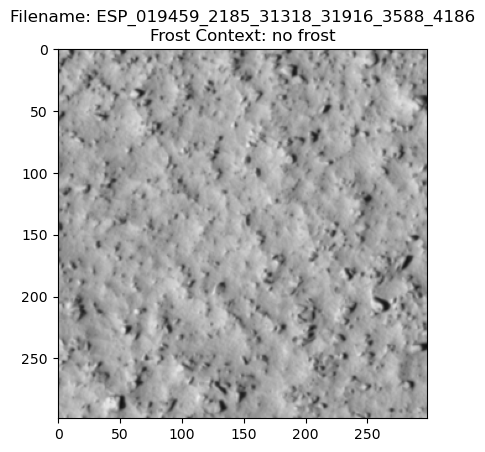

In [8]:
import matplotlib.pyplot as plt
import random

def display_random_image_and_json(some_data):
    # Pick a random image that has frost
    idx = random.choice(range(len(some_data)))
    tile_i = random.choice(range(len(some_data[idx]['tiles'])))
    img_dict = some_data[idx]['tiles'][tile_i]

    img = img_dict['tile']

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Set the title
    ax.set_title(
        f"Filename: {img_dict['file']}\nFrost Context: {decode_array_to_context(img_dict['frost_types'])}")

    plt.show()


display_random_image_and_json(train_data)


## Preprocess data

Gather and bin the data

In [9]:
# frost type categories = [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]

# Train Data
X_train = []
y_train = []
for i in range(len(train_data)):
    for j in range(len(train_data[i]['tiles'])):
        X_train.append(train_data[i]['tiles'][j]['tile'])
        y_train.append(train_data[i]['tiles'][j]['frost_types'])

# Validate Data
X_val = []
y_val = []
for i in range(len(validate_data)):
    for j in range(len(validate_data[i]['tiles'])):
        X_val.append(validate_data[i]['tiles'][j]['tile'])
        y_val.append(validate_data[i]['tiles'][j]['frost_types'])

# Test Data
X_test = []
y_test = []
for i in range(len(test_data)):
    for j in range(len(test_data[i]['tiles'])):
        X_test.append(test_data[i]['tiles'][j]['tile'])
        y_test.append(test_data[i]['tiles'][j]['frost_types'])

Format the data

In [10]:
# Convert lists to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Normalize the data
# X_train = X_train / 255.0
# X_val = X_val / 255.0
# X_test = X_test / 255.0

# # Reshape the data
# X_train = X_train.reshape(-1,299,299,1)
# X_val = X_val.reshape(-1, 299, 299, 1)
# X_test = X_test.reshape(-1, 299, 299, 1)

###### Shuffle the training set ######
indices = np.arange(X_train.shape[0])

# First shuffle the indices
np.random.shuffle(indices)

# Then use the shuffled indices to shuffle data and labels
X_train = X_train[indices]
y_train = y_train[indices]

Make sure it's formatted correctly

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(14119, 299, 299, 3)
(14119, 6)
(7889, 299, 299, 3)
(7889, 6)
(7972, 299, 299, 3)
(7972, 6)


## Import Tensorflow Packages

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2023-07-26 12:39:46.741928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 12:39:48.639570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
12:39:50 | INFO  | utils           | Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
12:39:50 | INFO  | utils           | Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
12:39:50 | INFO  | utils           | NumExpr defaulting to 8 threads.


## Augment the data

In [13]:
# Define the data augmentation parameters
aug_imgs = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

aug_imgs.fit(X_train)

## Fine Tune InceptionV3

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False

2023-07-26 12:40:15.388402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14585 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [15]:
# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='sigmoid')(x)  # '6' is the number of classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
import tensorflow as tf

def hamming_loss(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred >= 0.5, dtype=tf.float32)
    elementwise_equal = tf.equal(y_true, y_pred_binary)
    false_count = tf.reduce_sum(
        tf.cast(tf.logical_not(elementwise_equal), dtype=tf.float32))
    # Divide by total number of labels
    loss = false_count / tf.cast(tf.size(y_true), dtype=tf.float32)
    return loss


def frost_presence_accuracy(y_true, y_pred):
    # Convert predictions to binary
    y_pred_binary = tf.cast(y_pred >= 0.5, dtype=tf.float32)

    # Compute sums of true and predicted labels
    y_true_sum = tf.reduce_sum(y_true, axis=-1)
    y_pred_sum = tf.reduce_sum(y_pred_binary, axis=-1)

    # Compute boolean tensors where True indicates that the sum of labels are either both zero or both non-zero
    sums_are_both_zero = tf.logical_and(
        tf.equal(y_true_sum, 0), tf.equal(y_pred_sum, 0))
    sums_are_both_non_zero = tf.logical_and(
        tf.not_equal(y_true_sum, 0), tf.not_equal(y_pred_sum, 0))

    # Combine the two conditions
    correct_condition = tf.logical_or(
        sums_are_both_zero, sums_are_both_non_zero)

    # Cast boolean tensor to float32 and compute mean
    accuracy = tf.reduce_mean(tf.cast(correct_condition, dtype=tf.float32))

    return accuracy

In [17]:
# Let's say you want a learning rate of 0.001
opt = Adam(learning_rate=0.001)

# Then compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[hamming_loss, frost_presence_accuracy])

In [18]:
batch_size = 200
epochs = 20

Give this roughly 3-4 minutes to run

In [19]:
# Assuming you already have the corresponding labels in y_train, y_val, y_test
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size)

validation_generator = valid_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=1,
    shuffle=False)

## Train the model

In [20]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
max_steps = len(X_train) // batch_size
steps = max_steps // 10

history = model.fit(
    train_generator,
    steps_per_epoch = steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = steps)

Epoch 1/20


2023-07-26 12:40:38.480483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-26 12:40:40.984028: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-07-26 12:40:42.022815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-26 12:40:53.871126: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f33640ab470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-26 12:40:53.871166: I tensorflow/compiler/xla/service/service.cc:177]  

7/7 [==============================] - ETA: 0s - loss: 4.0662 - hamming_loss: 0.1523 - frost_presence_accuracy: 0.7114

2023-07-26 12:41:00.220742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 28s 2s/step - loss: 4.0662 - hamming_loss: 0.1523 - frost_presence_accuracy: 0.7114 - val_loss: 3.5121 - val_hamming_loss: 0.1087 - val_frost_presence_accuracy: 0.6657
Epoch 2/20
7/7 [==============================] - 13s 2s/step - loss: 1.4708 - hamming_loss: 0.0662 - frost_presence_accuracy: 0.8407 - val_loss: 1.8632 - val_hamming_loss: 0.1251 - val_frost_presence_accuracy: 0.4929
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.4922 - hamming_loss: 0.0554 - frost_presence_accuracy: 0.8714 - val_loss: 1.0150 - val_hamming_loss: 0.1261 - val_frost_presence_accuracy: 0.5807
Epoch 4/20
7/7 [==============================] - 13s 2s/step - loss: 0.2669 - hamming_loss: 0.0525 - frost_presence_accuracy: 0.8564 - val_loss: 0.4973 - val_hamming_loss: 0.0935 - val_frost_presence_accuracy: 0.6529
Epoch 5/20
7/7 [==============================] - 13s 2s/step - loss: 0.2056 - hamming_loss: 0.0560 - frost_presence_accuracy: 0.8707 - val

## Save the weights as a .h5 file
Also save the history of the model as a .csv file

In [21]:
import pandas as pd
model.save('vgg16_200_20_1024.h5')
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'vgg16_200_20_1024.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate the model
Using our custom metrics. Load in the file.

In [22]:
import pandas as pd
from tensorflow.keras.models import load_model

# Register the custom metric function
with tf.keras.utils.custom_object_scope({'hamming_loss': hamming_loss, 'frost_presence_accuracy': frost_presence_accuracy}):
    my_model = load_model('vgg16_200_20_1024.h5')

my_model_history = pd.read_csv(
    'vgg16_200_20_1024.csv')


## Random prediction models (2)
* Predict all 0's
* Choose 0's and 1's at random
* Demonstrates how much better our model is than random

In [23]:
def predict_zeros(X_data):
    # return an array of [0,0,0,0,0,0] for each X_train
    return np.zeros((X_data.shape[0], 6))

def predict_random(X_data):
    # return an array of random 0's and 1's [x,x,x,x,x,x] for each X_train
    return np.random.choice([0, 1], size=(X_data.shape[0], 6))

In [24]:
predict_zeros = predict_zeros(X_test)
predict_random = predict_random(X_test)
predictions = my_model.predict(X_test)

250/250 [==============================] - 21s 73ms/step


In [25]:
predictions_decimal = np.round(predictions, 2)
predictions_round = np.where(predictions >= 0.6, 1, 0)

In [26]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import hamming_loss

# Compute the Hamming loss for each predictor
hamming_loss_zeros = hamming_loss(y_test, predict_zeros)
hamming_loss_random = hamming_loss(y_test, predict_random)
hamming_loss_cnn = hamming_loss(y_test, predictions_round)

fp_acc_zeros = frost_presence_accuracy(y_test, predict_zeros)
fp_acc_random = frost_presence_accuracy(y_test, predict_random)
fp_acc_cnn = frost_presence_accuracy(y_test, predictions_round)
# print all
print(f"Hamming Loss for Zeros: {hamming_loss_zeros}")
print(f"Hamming Loss for Random: {hamming_loss_random}")
print(f"Hamming Loss for CNN: {hamming_loss_cnn}")

print(f"Frost Presence Accuracy for Zeros: {fp_acc_zeros}")
print(f"Frost Presence Accuracy for Random: {fp_acc_random}")
print(f"Frost Presence Accuracy for CNN: {fp_acc_cnn}")

Hamming Loss for Zeros: 0.16965629703963875
Hamming Loss for Random: 0.4989337681886603
Hamming Loss for CNN: 0.13614316775380497
Frost Presence Accuracy for Zeros: 0.36615654826164246
Frost Presence Accuracy for Random: 0.6305820345878601
Frost Presence Accuracy for CNN: 0.6805067658424377


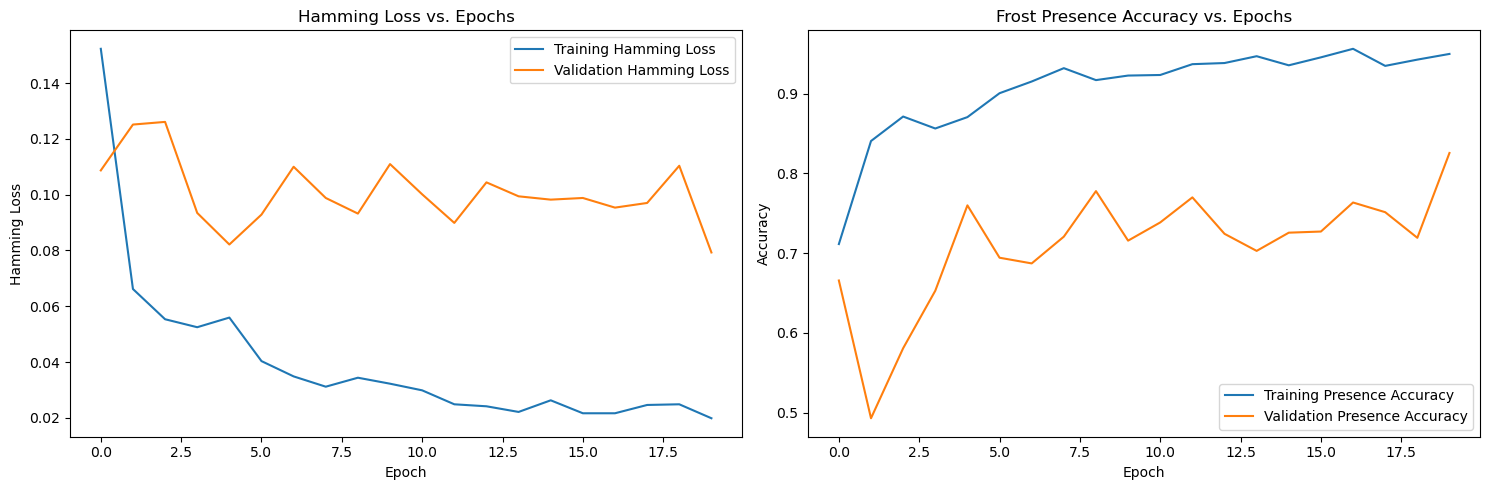

In [27]:
import matplotlib.pyplot as plt

# Create a new figure with a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the training and validation Hamming loss on the first subplot
axes[0].plot(my_model_history['hamming_loss'], label='Training Hamming Loss')
axes[0].plot(my_model_history['val_hamming_loss'],
             label='Validation Hamming Loss')

# Label the axes of the first subplot
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Hamming Loss')
axes[0].set_title('Hamming Loss vs. Epochs')

# Add a legend to the first subplot
axes[0].legend()

# Plot the training and validation accuracy on the second subplot
axes[1].plot(my_model_history['frost_presence_accuracy'],
             label="Training Presence Accuracy")
axes[1].plot(my_model_history['val_frost_presence_accuracy'],
             label="Validation Presence Accuracy")

# Label the axes of the second subplot
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Frost Presence Accuracy vs. Epochs')

# Add a legend to the second subplot
axes[1].legend()

# Display the plot
plt.tight_layout()
plt.show()
